In [601]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
plt.rcparams = {"fontsize": 16}
fig_params = {"dpi": 100, "figsize": (7, 7)}

In [602]:
# Количество приемных устройств
K = 15

# Расстояние между приемниками
d = 0.7
d1 = 2 * np.pi * d


M = 2 * K

# k - волновое число
k = 2 * np.pi

# ND
ND = 100 / (2 * K + 1)
ND = 1

# Один радиан в градусах
rad_in_grad = 180 / np.pi 

# Отход от центра наблюдения целей
s = 1/ (0.82 * (M + 1) * d * 2)
s1 = 1.4 * s
dt = 0.1 * s
ds = 0.2 * s
ds1 = 0.01 * s1
sss = 0.01

# Сетки
dtn = np.arange(-s, s + dt, dt)
a = np.arange(-s1, s1 + ds1, ds1)
a1 = np.arange(0, 0.125 * k + ds, ds)

In [603]:
s

0.028099359334607176

In [604]:
def F(t, alpha = 0):
    result = 0
    for n in np.arange(1, K + 1):
        result += np.cos(k * d * n * (t - alpha))
    return result * 2 * ND + ND

def Fexp(t, alpha = 0):
    result = 0 + 0j
    for n in np.arange(0, K):
        result += np.exp(-1j * (k * d * (n - K) * (t - alpha))) + np.exp(1j * (k * d * (n - K) * (t - alpha))) 
    return result * ND + ND

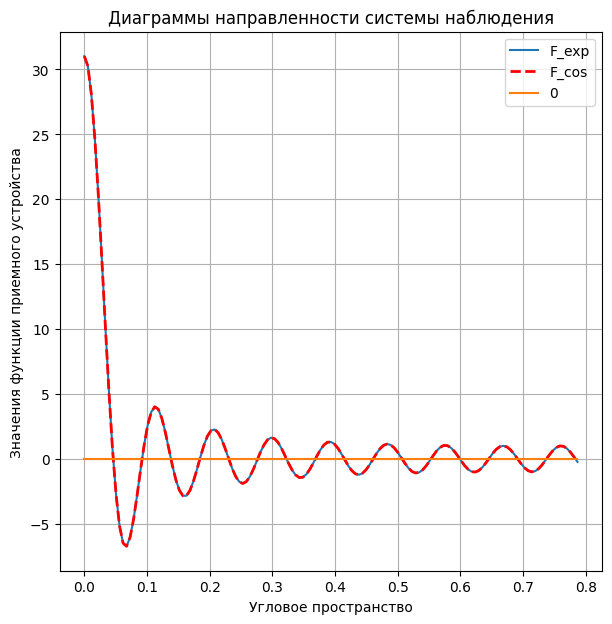

In [605]:
plt.figure(**fig_params)
plt.title("Диаграммы направленности системы наблюдения")
plt.plot(a1, np.real(Fexp(a1)), label = "F_exp")
plt.plot(a1, F(a1), linestyle = "--", 
         linewidth = 2, color= "r", label = "F_cos")
plt.plot(a1, np.zeros(a1.shape), label = "0")
plt.xlabel("Угловое пространство")
plt.ylabel("Значения функции приемного устройства")
plt.legend()
plt.grid()
plt.show()

In [606]:
magnitude = 600
multiplier = 53.5
phase = 0
power = 18
bias = 0

def Idel(t):
    return (magnitude * (np.sin(multiplier * (t + phase * s))**power + bias)) * (np.abs(t) < s1)

In [607]:
def integrand(t, alpha):
    return F(t - alpha) * Idel(t)

def U00(a):
    return integrate.quad(integrand, -s1, s1, args = (a, ))[0]

vec_U00 = np.vectorize(U00)

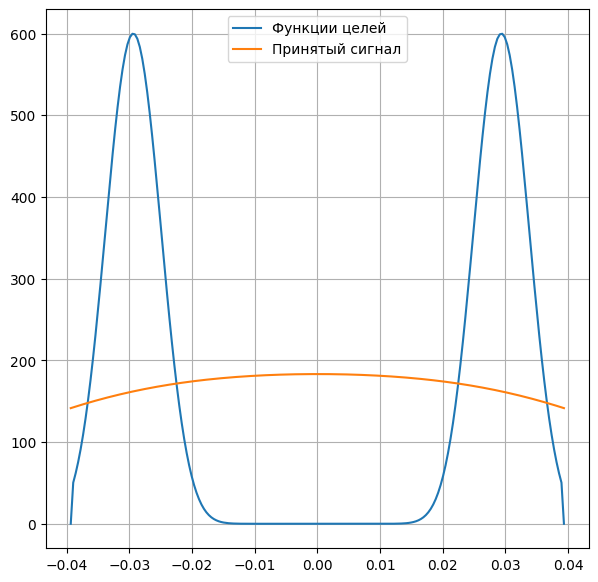

In [608]:
plt.figure(**fig_params)
plt.plot()
plt.plot(a, Idel(a), label = "Функции целей")
plt.plot(a, vec_U00(a), label = "Принятый сигнал")
plt.legend()
plt.grid()
plt.show()

## Прогнозирование $C_n$

In [609]:
NP = 104
NPa = np.arange(1, NP + 1)

In [610]:
def integrand_Cn(t, n = 1):
    return np.cos(k * d * n * t) * Idel(t)

# def Cn(n):
#     return integrate.quad(integrand_Cn, -s1, s1, args = (n, ))[0] * (1 + 0.5 * np.random.uniform(0, 0.1, 1))

# vec_Cn = np.vectorize(Cn)

In [611]:
def integral_of_func(func, lower = -1, upper = 1, N = 1000, **kwargs):
    h = (upper - lower) / N
    array_1d = np.arange(lower + h, upper + h, h)
    result = np.sum(func(array_1d, **kwargs) * h)
    return result 

In [612]:
int_func = np.vectorize(integral_of_func)

In [613]:
Cn = int_func(func=integrand_Cn, lower = -1, upper=1, N = 20000, n = NPa)

In [614]:
C = Cn[:K+1]
CR = Cn[K+1:]

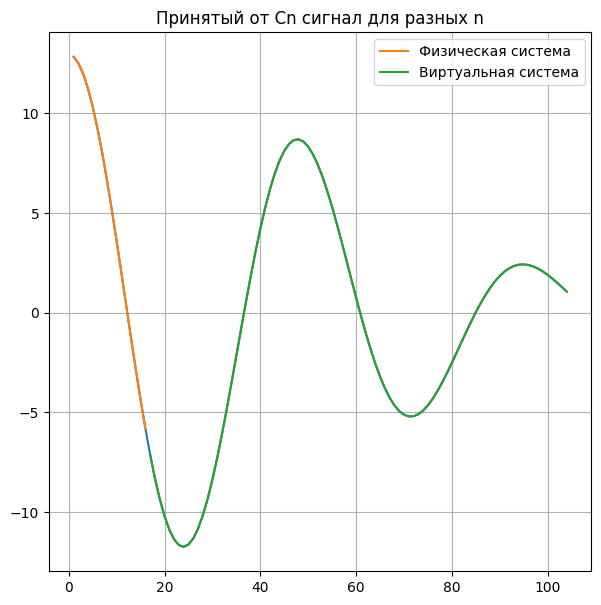

In [615]:
plt.figure(**fig_params)
plt.title("Принятый от Cn сигнал для разных n")
plt.plot(NPa, Cn)
plt.plot(NPa[:K+1], C, label = "Физическая система")
plt.plot(NPa[K+1:], CR, label = "Виртуальная система")
plt.legend()
plt.grid()

## Авторегрессионная нейросеть 

In [616]:
# Формирование выборки
X_input = 5
Y_output = 1
window_size = (X_input + Y_output, )
A_matrix = np.lib.stride_tricks.sliding_window_view(C, window_shape = window_size)

X_matrix = A_matrix[:, :X_input]
Y_matrix = A_matrix[:, X_input:]

In [617]:
from sklearn.neural_network import MLPRegressor

In [618]:
regr = MLPRegressor(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(18, 5), random_state=1, activation = "relu")

In [619]:
regr.fit(X_matrix, Y_matrix[:, 0])

MLPRegressor(alpha=1e-05, hidden_layer_sizes=(18, 5), random_state=1,
             solver='lbfgs')

In [620]:
regr.predict(C[-X_input:].reshape(1, -1))

array([-6.93309216])

In [621]:
CRegr = C.copy()
for fut in np.arange(K+1, NP):
    CRegr = np.append(CRegr, regr.predict(CRegr[-X_input:].reshape(1, -1)))

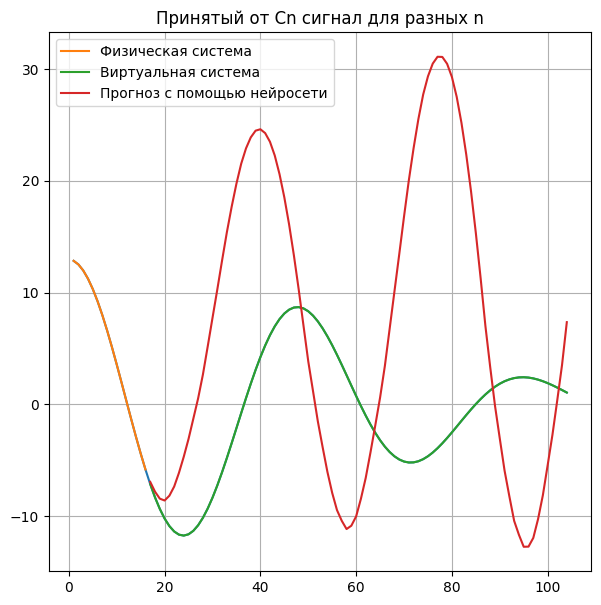

In [622]:
plt.figure(**fig_params)
plt.title("Принятый от Cn сигнал для разных n")
plt.plot(NPa, Cn)
plt.plot(NPa[:K+1], C, label = "Физическая система")
plt.plot(NPa[K+1:], CR, label = "Виртуальная система")
plt.plot(NPa[K+1:], CRegr[K+1:], label = "Прогноз с помощью нейросети")
plt.legend()
plt.grid()

## Интерполяция

In [623]:
# Данные для прогнозирования
interp_times = 10
x_interp = np.arange(0, K + 1/(interp_times+1), 1/interp_times)    # Сетка 
C_interp = np.interp(x_interp, np.arange(0, K+1), C)               # Линейная интерполяция

x_interp_future = np.arange(x_interp[-1] + 1/interp_times, NP + 1/(interp_times + 1), 1/interp_times)

In [624]:
X_input = 40
Y_output = 1
window_size = (X_input + Y_output, )
A_matrix = np.lib.stride_tricks.sliding_window_view(C_interp, window_shape = window_size)

X_matrix = A_matrix[:, :X_input]
Y_matrix = A_matrix[:, X_input:]

In [625]:
regr = MLPRegressor(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(18, 3), random_state=1, activation = "relu", max_iter = 1000)

In [626]:
regr.fit(X_matrix, Y_matrix[:, 0])

MLPRegressor(alpha=1e-05, hidden_layer_sizes=(18, 3), max_iter=1000,
             random_state=1, solver='lbfgs')

In [627]:
CRegr = C_interp.copy()
for fut in x_interp_future:
    CRegr = np.append(CRegr, regr.predict(CRegr[-X_input:].reshape(1, -1)))

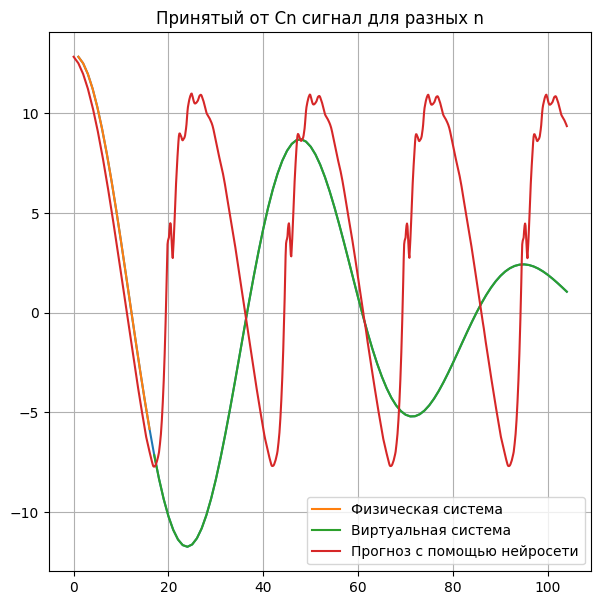

In [628]:
plt.figure(**fig_params)
plt.title("Принятый от Cn сигнал для разных n")
plt.plot(NPa, Cn)
plt.plot(NPa[:K+1], C, label = "Физическая система")
plt.plot(NPa[K+1:], CR, label = "Виртуальная система")
plt.plot(np.append(x_interp, x_interp_future), CRegr, label = "Прогноз с помощью нейросети")
plt.legend()
plt.grid()

## Активное дообучение

In [629]:
X_input = len(C) - 1
Y_output = 1
window_size = (X_input + Y_output, )

regr = MLPRegressor(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(X_input, int(X_input / 2)), random_state=1, activation = "relu", max_iter = 1000)

CRegr = C.copy()
for fut in np.arange(K+1, NP):
    A_matrix = np.lib.stride_tricks.sliding_window_view(CRegr, window_shape = window_size)
    X_matrix = A_matrix[:, :X_input]
    Y_matrix = A_matrix[:, X_input:]
    regr.fit(X_matrix, Y_matrix[:, 0])
    x_interp = np.append(x_interp, np.array([x_interp[-1], 1/interp_times]))
    CRegr = np.append(CRegr, regr.predict(CRegr[-X_input:].reshape(1, -1)))


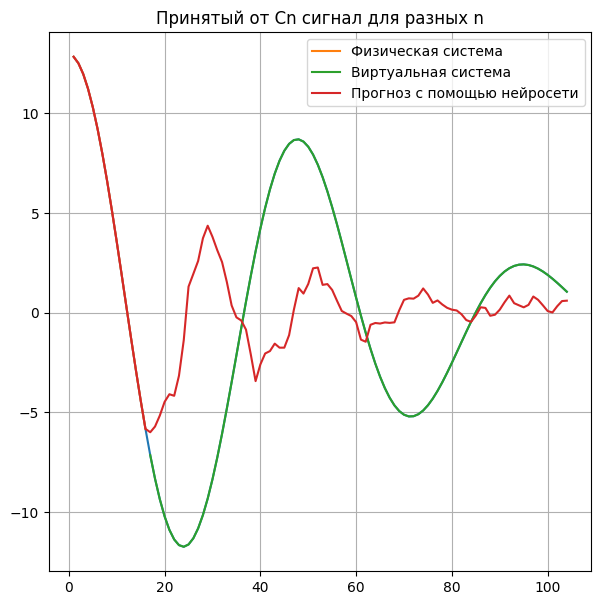

In [630]:
plt.figure(**fig_params)
plt.title("Принятый от Cn сигнал для разных n")
plt.plot(NPa, Cn)
plt.plot(NPa[:K+1], C, label = "Физическая система")
plt.plot(NPa[K+1:], CR, label = "Виртуальная система")
plt.plot(NPa, CRegr, label = "Прогноз с помощью нейросети")
plt.legend()
plt.grid()

## Обучение на симметричной области

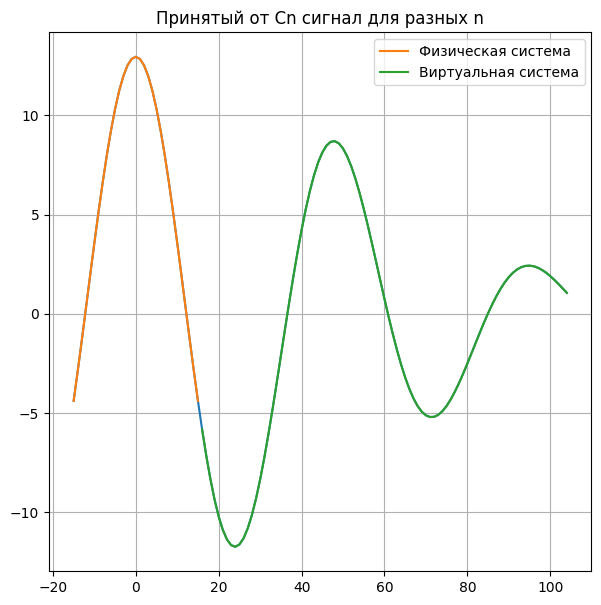

In [646]:
NP = 104
NPa = np.arange(0, NP + 1)
NPa_full = np.arange(-K, NP + 1)

given_field = np.arange(-K, K+1)

Cn = int_func(func=integrand_Cn, lower = -1, upper=1, N = 20000, n = NPa_full)

C = Cn[:len(given_field)]
CR = Cn[len(given_field):]
NPa_CR = NPa_full[len(given_field):]

plt.figure(**fig_params)
plt.title("Принятый от Cn сигнал для разных n")
plt.plot(NPa_full, Cn)
plt.plot(given_field, C, label = "Физическая система")
plt.plot(NPa_CR, CR, label = "Виртуальная система")
plt.legend()
plt.grid()

In [845]:
X_input = K
Y_output = 1
window_size = (X_input + Y_output, )
A_matrix = np.lib.stride_tricks.sliding_window_view(C, window_shape = window_size)

X_matrix = A_matrix[:, :X_input]
Y_matrix = A_matrix[:, X_input:]

regr = MLPRegressor(solver='sgd', alpha=1e-4,
                    hidden_layer_sizes=(14, 3), random_state=1, activation = "tanh", max_iter = 1000)

In [846]:
regr.fit(X_matrix, Y_matrix[:, 0])

MLPRegressor(activation='tanh', hidden_layer_sizes=(14, 3), max_iter=1000,
             random_state=1, solver='sgd')

In [847]:
CRegr = C.copy()
for fut in NPa_CR:
    CRegr = np.append(CRegr, regr.predict(CRegr[-X_input:].reshape(1, -1)))

In [848]:
CRegr.shape

(120,)

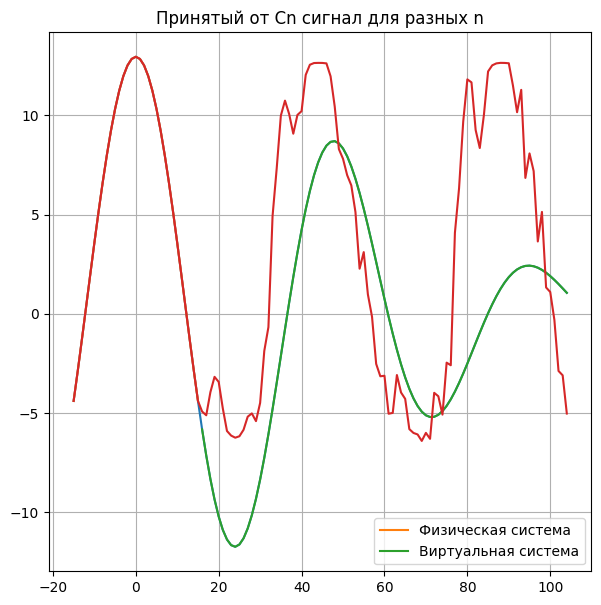

In [849]:
plt.figure(**fig_params)
plt.title("Принятый от Cn сигнал для разных n")
plt.plot(NPa_full, Cn)
plt.plot(given_field, C, label = "Физическая система")
plt.plot(NPa_CR, CR, label = "Виртуальная система")
plt.plot(NPa_full, CRegr)
plt.legend()
plt.grid()

## Интерполяция сплайнами

In [850]:
NP = 104
NPa = np.arange(0, NP + 1)
NPa_full = np.arange(-K, NP + 1)

given_field = np.arange(-K, K+1)

C = int_func(func=integrand_Cn, lower = -1, upper=1, N = 20000, n = given_field)
Cn = int_func(func=integrand_Cn, lower = -1, upper=1, N = 20000, n = NPa_full)

In [851]:
# Интерполяция
from scipy.interpolate import CubicSpline

cs = CubicSpline(given_field, C)

In [852]:
# Данные для прогнозирования
interp_times = 10
x_interp = np.arange(-K, K + 1/(interp_times+1), 1/interp_times)    # Сетка 
C_interp = cs(x_interp)               # Линейная интерполяция

x_interp_future = np.arange(x_interp[-1] + 1/interp_times, NP + 1/(interp_times + 1), 1/interp_times)

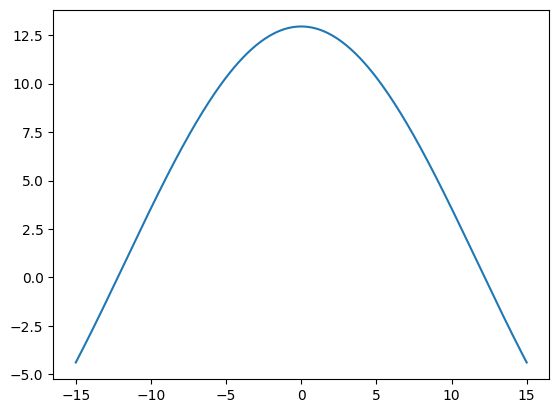

In [853]:
plt.plot(x_interp, C_interp)

In [1031]:
X_input = K * 2
Y_output = 1
window_size = (X_input + Y_output, )
A_matrix = np.lib.stride_tricks.sliding_window_view(C_interp, window_shape = window_size)

X_matrix = A_matrix[:, :X_input]
Y_matrix = A_matrix[:, X_input:]

regr = MLPRegressor(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(20, 8), random_state=1, activation = "relu", max_iter = 1000)

In [1032]:
regr.fit(X_matrix, Y_matrix[:, 0])

MLPRegressor(alpha=1e-05, hidden_layer_sizes=(20, 8), max_iter=1000,
             random_state=1, solver='lbfgs')

In [1033]:
X_matrix.shape

(271, 30)

In [1034]:
CRegr = C_interp.copy()
for fut in x_interp_future:
    CRegr = np.append(CRegr, regr.predict(CRegr[-X_input:].reshape(1, -1)))

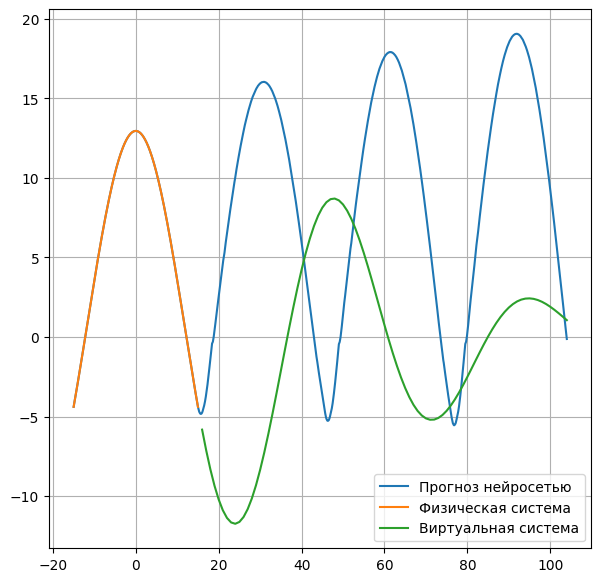

In [1035]:
plt.figure(**fig_params)
plt.plot(np.append(x_interp, x_interp_future), CRegr, label = "Прогноз нейросетью")
plt.plot(x_interp, C_interp, label = "Физическая система")
plt.plot(NPa_CR, CR, label = "Виртуальная система")
plt.legend()
plt.grid()
plt.show()